# Example - markup_images  
> **Model trained On the AM0.1-FLUKE dataset**  
Load the model and run inferences on the test dataset   
**[Run this file online in Colab](https://colab.research.google.com/github/johnnewto/cellsegment/blob/master/nbs/23_example_evaluation_inference.ipynb)**

## Setup environment

In [35]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
def in_colab():
    "Check if the code is running in Google Colaboratory"
    try:
        from google import colab
        return True
    except: return False
IN_COLAB = in_colab()

In [36]:
#hide
if IN_COLAB:
    import os
    print('Cloning the cellsegment library')
    os.system('mkdir -p /root/.torch/models')
    os.system('mkdir -p /root/.fastai/data')
    os.system('ln -s /root/.torch/models /content')
    os.system('ln -s /root/.fastai/data /content')
    os.system('rm -rf /content/sample_data/')

### Imports

In [37]:
from cellsegment.core import *
from cellsegment.inference_utils import *
from cellsegment.json_utils import *
from cellsegment.dataprep_utils import *
from cellsegment.set_directories import *
from cellsegment.markup_utils import *   #hide this otherwise recurseive 

import pandas
from fastai.vision import *

### Define directories

In [38]:
local_datapath = '../testdata_2'
# local_datapath = '../../data/FEC/03-M100-Fluke-2019-11/'

dirs = Dirs('data') if IN_COLAB else Dirs(local_datapath)
dirs.model = dirs.model if IN_COLAB else '/home/john/github/data/FEC/03-M100-Fluke-2019-11/models'

print(dirs)


None
  basepath        :  ../testdata_2        
  crop            :  ../testdata_2/Crop-200 
  cropLabel       :  ../testdata_2/Crop-200/Label 
  cropTest        :  ../testdata_2/Crop-200/Test 
  cropTrain       :  ../testdata_2/Crop-200/Train 
  cropValidTxtFile:  ../testdata_2/Crop-200/valid.txt 
  label           :  ../testdata_2/Fullsize/Label 
  model           :  /home/john/github/data/FEC/03-M100-Fluke-2019-11/models 
  originImages    :  ../testdata_2/Original 
  sizeCsvFile     :  ../testdata_2/file_size.csv 
  test            :  ../testdata_2/Fullsize/Test 
  train           :  ../testdata_2/Fullsize/Train 
  validTxtFile    :  ../testdata_2/Fullsize/valid.txt 



### Load the Training Images 
(if in colab)

In [39]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab

    export fileid=1SEW0Kf1CI4e4-up4TGsDqwDwVk_QZEUf
    export filename=Fluke-Train-2019-12-01.zip

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
    
    unzip -u -q $filename -d data

### Load exported Model

In [40]:
%%bash
[[ ! -e /tools/google-cloud-sdk ]] &&  exit # if in colab
switch=true
if $switch; then  
    export fileid=11cZWhg23QDag_3b7jcd02U8Pzq3W6U5Y
    export filename=export-fluke-2019-12-01.pkl

    ## CURL ##
    curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid \
         | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
    curl -L -b cookies.txt -o $filename \
         'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)
    rm -f confirm.txt cookies.txt
fi

### Create Learner from exported model

In [41]:
# defaults.device = 'cpu'
defaults.device = 'cuda'
if torch.cuda.is_available():

    def acc_metric1(input, target):
        target = target.squeeze(1)
        return (input.argmax(dim=1)==target).float().mean()

    def acc_metric2(input, target):
        target = target.squeeze(1)
        return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()

    fn_model = f'{dirs.model}/export-fluke-2019-12-01.pkl'
    learn = load_learner('', fn_model)

    learn.model.float()
    # summary(learn.model, (3, 32, 32))
    print("Learner loaded")
else:
    print("Learner not loaded as torch.cuda.is_available() = ", torch.cuda.is_available())
    

Learner loaded


> Run a prediction on a test image

In [42]:
img_path = Path(dirs.train)
mrk_path = Path(dirs.train+'/../markup')  
mrk_path.mkdir(parents=True, exist_ok=True)
fnames = sorted(get_image_files(img_path))
fn = fnames[1]
fn

PosixPath('../testdata_2/Fullsize/Train/236568 - 10.jpg')

Saving Background torch.Size([800, 816])
Saving Liver Fluke torch.Size([800, 816])
Saving Rumen Fluke torch.Size([800, 816])
Saving Other torch.Size([800, 816])
Background torch.Size([800, 816])
Liver Fluke torch.Size([800, 816])
Rumen Fluke torch.Size([800, 816])
Other torch.Size([800, 816])


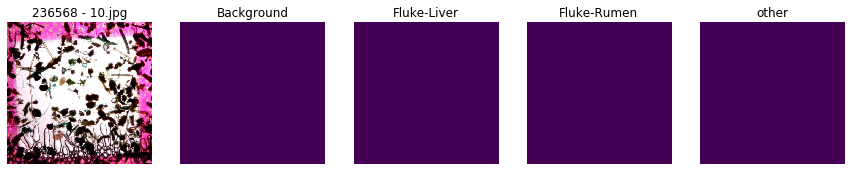

In [43]:
preds = run_prediction(learn, fn, tile=False, filesavedir=mrk_path)
for  cls, img in list(preds.items()):
    print(cls, img.shape)

# for cls,raw_pred in preds.items():
#     img = np.asarray(PIL.Image.open(fn))
#     show_img(img)
#     save_png_p(to_np(raw_pred), f'{mrk_path}/{fn.stem}-{cls}.png')


fig, axes = plt.subplots(1, 5, figsize=(15, 3))
ax = axes.flat[0]
img = open_image(fn)
im = ax.imshow(img.data.permute(1,2,0).numpy())
ax.set_axis_off()
ax.set_title(fn.name)
titles = ['Background','Fluke-Liver','Fluke-Rumen','other']
for i, ax in enumerate(axes.flat[1:]):
    arr = np.asarray(PIL.Image.open(f'{mrk_path}/{fn.stem}-{cls}.png'))
    im = ax.imshow(arr)
    ax.set_axis_off()
    ax.set_title(titles[i])

In [44]:
print("Class labels")
CLASS_LABELS

Class labels


{'Background': {'Code': '0', 'Fill': (0, 0, 0, 127)},
 'Liver Fluke': {'Code': '11', 'Fill': (255, 0, 0, 127)},
 'Rumen Fluke': {'Code': '40', 'Fill': (0, 255, 0, 127)},
 'Other': {'Code': '255', 'Fill': (0, 0, 255, 127)}}

## Marking up an image

../testdata_2/Fullsize/Train/236568 - 10.jpg


[{'label': 'Liver Fluke', 'point': [767, 177], 'probability': 69},
 {'label': 'Liver Fluke', 'point': [312, 336], 'probability': 100},
 {'label': 'Liver Fluke', 'point': [288, 649], 'probability': 99},
 {'label': 'Liver Fluke', 'point': [771, 684], 'probability': 83},
 {'label': 'Other', 'point': [764, 176], 'probability': 70}]

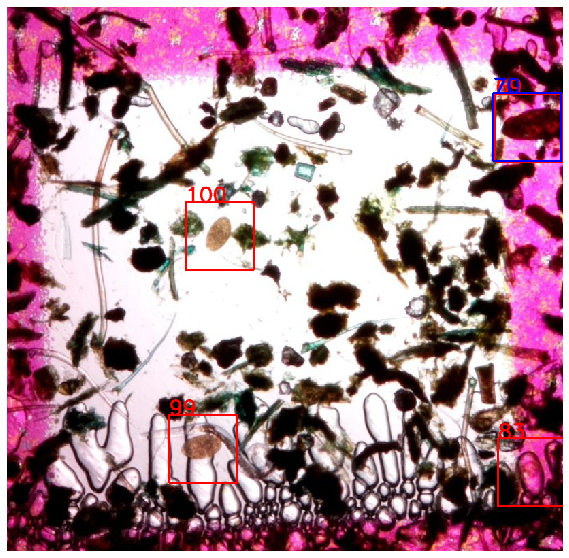

In [45]:
mrk_img, pred_list, jdata = markup_one_image(fn, preds)
show_img(mrk_img, figsize=(10,10))
print(fn)
pred_list

In [46]:
fn
# img_path = Path(dirs.train)
# mrk_path = Path('../testdata_2/Fullsize/markup')  
# mrk_path.mkdir(parents=True, exist_ok=True)
# 
# fnames = sorted(get_image_files(img_path))
# fnames = fnames[:3]
# classes = ['Background', 'Fluke_Liver', 'Fluke_Rumen', 'Other']
# 
# fn = fnames[1]
# preds = run_prediction(learn, fn, classes=classes, tile=False, filesavedir=mrk_path)
# 

PosixPath('../testdata_2/Fullsize/Train/236568 - 10.jpg')

In [47]:
# preds
# predictions, img, regions = find_prediction_blobs( to_np(preds['Fluke_Liver']))
# show_img(img, figsize=(8,8))
# regions
# # annotate_json


